In [1]:
import numpy as np
import matplotlib.pyplot as plt

import histlite as hl
plt.rcParams['figure.figsize'] = (10,25)
plt.rcParams['font.size'] = 14


# Define the test statistics

We model the counting experiment as a single Poisson distribution. The test statistic is therefore very easy to define. The likelihood is simply:
\begin{equation}
\mathcal{L} = \frac{(s+b)^k e^{-(s+b)}}{k!}
\end{equation}
where $s$ is the mean number of signal counts, $b$ is the mean number of background counts, and $k$ is the observed number of counts.

We use the common test statistic used in, for example, Cowan 2011 for profile likelihood ratio tests:

\begin{equation}
q_s = -2 \, \text{ln}\left( \frac{\mathcal{L}(s,b)}{\mathcal{L}(\hat{s},b)} \right)
\end{equation}

where $\hat{s}$ denotes the best-fit value of $s$ given the observed data $k$. Note that here we are assuming $b$ is known; otherwise $b$ would also be fit in both the numerator and the denominator, and would have hats over it. Working out this expression gives

\begin{equation}
q_s = 2\,\left[ s - \hat{s} - k\,\left( \text{ln}(s+b) - \text{ln}(\hat{s}+b) \right) \right]
\end{equation}
where
\begin{equation}
\hat{s} = 
\begin{cases}
0, & \text{if } k \leq b \\
k-b, & \text{if } k > b
\end{cases}
\end{equation}
because we are assuming that we can't have negative signal counts. 




In [2]:
# This function defines the test statistic for the counting experiment. 
# There are some 
def q_s(s,b,k):
    
    mask_k_zero = (k==0)
    mask_k_lt_b = (k<=b) & np.invert(mask_k_zero)
    mask_k_gt_b = (k>b) & np.invert(mask_k_zero)
    
    output = np.zeros(len(k))
    if s+b==0:
        return output
    
    k_zero = k[mask_k_zero]
    output[mask_k_zero] = 2 * (s)
    
    k_lt_b = k[mask_k_lt_b]
    output[mask_k_lt_b] = 2 * (s - k_lt_b*(np.log(s+b) - np.log(b)))

    k_gt_b = k[mask_k_gt_b]
    output[mask_k_gt_b] = 2 * (s  - (k_gt_b - b) - \
                                          k_gt_b*( np.log(s+b) - np.log(k_gt_b) ) )

    return output


    
# This function assumes k is constant; i.e. we are only looking at a single
# "experiment". 
def qscan(s,b,k):

    output = np.zeros(len(s))
    
    if k == 0:
        output = 2*s
        return output
    elif k <= b:
        sbest = 0.
    else:
        sbest = k-b
        
    output = k * (s-sbest - k*(np.log(s+b) - np.log(sbest+b)))
    return output




# Zero background case

In the case where there is truly zero background ($b=0$, exactly), the test statistic simplifies even further:

\begin{equation}
q_s = 2\,\left[ s - k - k\,\left( \text{ln}(s) - \text{ln}(k) \right) \right]
\end{equation}

To evaluate the value of the signal hypothesis at which the background-only data will meet a certain confidence limit, we need the distribution of $q_s$ at each value of $s$. In this case, this is easy to do; we simply generate Poisson random variables with a mean of $s$ and compute the relevant percentiles.

This gives rise to some funny behavior due to the discrete nature of the Poisson distribution. For example, if you evaluate $q_s$ for $s = 0.5$ and $s=1.0$, you get funny-looking distributions with large gaps.


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


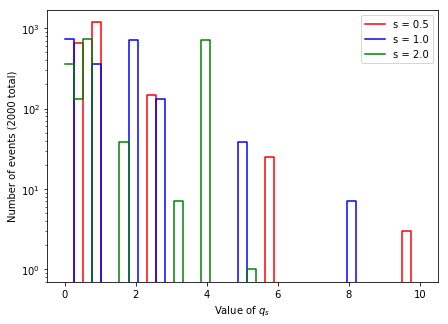

In [3]:
plt.rcParams['figure.figsize'] = (7,5)

test1 = np.random.poisson(lam=0.5,size=2000)
test2 = np.random.poisson(lam=1.,size=2000)

qtest1 = q_s(0.5,0.,test1)
qtest2 = q_s(1.,0.,test2)
qtest3 = q_s(2.,0.,test2)

htest1 = hl.hist(qtest1,bins=np.linspace(0.,10.,40))
hl.plot1d(htest1,color='r',label='s = 0.5')

htest2 = hl.hist(qtest2,bins=np.linspace(0.,10.,40))
hl.plot1d(htest2,color='b',label='s = 1.0')

htest3 = hl.hist(qtest3,bins=np.linspace(0.,10.,40))
hl.plot1d(htest3,color='g',label='s = 2.0')

plt.xlabel(r'Value of $q_s$')
plt.ylabel('Number of events (2000 total)')
plt.legend()

plt.yscale('log')


Then, the upper limit boundaries end up with a funny sawtooth shape, which has discrete jumps:

In [4]:
num_hypotheses = 250

hypotheses = np.linspace(0.,9.99,num_hypotheses)
limits_90 = np.zeros(num_hypotheses)
limits_99 = np.zeros(num_hypotheses)
limits_68 = np.zeros(num_hypotheses)

for i in range(num_hypotheses):
    if i % 50 == 0:
        print(i)
    hyp = hypotheses[i]
    
    test = np.random.poisson(lam=hyp,size=300000)
    qtest = q_s(hyp,0.,test)
    
    limits_90[i] = np.quantile(qtest,0.9)
    limits_99[i] = np.quantile(qtest,0.99)
    limits_68[i] = np.quantile(qtest,0.68)
    
    
    


0


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


50
100
150
200


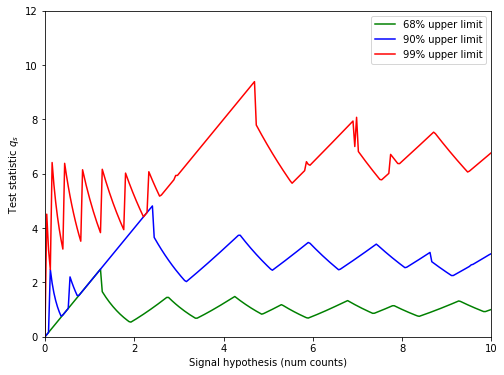

In [5]:
plt.rcParams['figure.figsize'] = (8,6)

plt.plot(hypotheses,limits_68,'g',label='68% upper limit')
plt.plot(hypotheses,limits_90,'b',label='90% upper limit')
plt.plot(hypotheses,limits_99,'r',label='99% upper limit')

plt.xlim(0.,10.)
plt.ylim(0.,12.)
plt.legend()
plt.xlabel('Signal hypothesis (num counts)')
plt.ylabel(r'Test statistic $q_s$')

output = np.transpose( np.vstack((hypotheses,limits_90)) )
np.savetxt('critical_lambda_analytical_0bkg.txt',output)


If 0 events are observed, then one now scans the value of the test statistic across various signal hypothesis, and the upper limit of the confidence interval is where this scan crosses the upper limit curves calculated above.

When 0 events are observed, $k=0$, and the test statistic reduces to just:

\begin{equation}
q_s = 2s
\end{equation}

And it's easy to see that this curve will cross the upper limit threshold at the first big sawtooth:


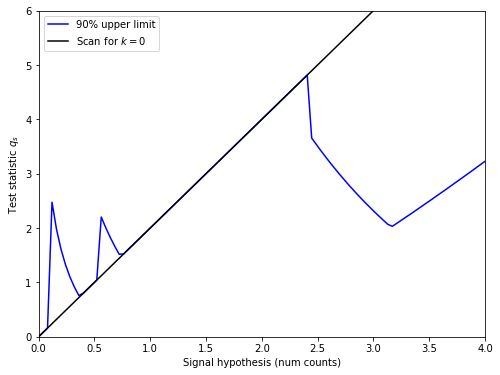

In [6]:
q_scan = 2 * hypotheses

plt.plot(hypotheses,limits_90,'b',label='90% upper limit')
plt.plot(hypotheses,q_scan,'-k',label=r'Scan for $k = 0$')


plt.xlabel('Signal hypothesis (num counts)')
plt.ylabel(r'Test statistic $q_s$')

plt.xlim(0.,4.)
plt.ylim(0.,6.)
plt.legend()



The crossing happens exactly at 2.44cts, which reproduces precisely the results from the Feldman Cousins paper.

# Nonzero background case

Next, we can compute the same things for counting experiments with nonzero backgrounds.

In [7]:
hypotheses = np.linspace(0.,4.99,250)

bkg_limits_90 = dict()
bkg_limits_68 = dict()
bkg_limits_99 = dict()

for bkg_level_str in ['0.01','0.1','0.3','0.5','1.0','1.5','2.0','2.5','3.0','4.0']:

    bkg_level = float(bkg_level_str)
    
    print('Background counts: {:03.3}'.format(bkg_level))

    this_bkg_limits_90 = np.zeros(250)
    this_bkg_limits_99 = np.zeros(250)
    this_bkg_limits_68 = np.zeros(250)

    for i in range(250):
        if i % 100 == 0:
            print(i)
        hyp = hypotheses[i]

        test = np.random.poisson(lam=(hyp+bkg_level),size=300000)
        qtest = q_s(hyp,bkg_level,test)

        this_bkg_limits_90[i] = np.quantile(qtest,0.9)
        this_bkg_limits_99[i] = np.quantile(qtest,0.99)
        this_bkg_limits_68[i] = np.quantile(qtest,0.68)
        
    bkg_limits_90[bkg_level_str] = this_bkg_limits_90
    bkg_limits_99[bkg_level_str] = this_bkg_limits_99
    bkg_limits_68[bkg_level_str] = this_bkg_limits_68
    

Background counts: 0.01
0
100
200
Background counts: 0.1
0
100
200
Background counts: 0.3
0
100
200
Background counts: 0.5
0
100
200
Background counts: 1.0
0
100
200
Background counts: 1.5
0
100
200
Background counts: 2.0
0
100
200
Background counts: 2.5
0
100
200
Background counts: 3.0
0
100
200
Background counts: 4.0
0
100
200


## Comparison with Feldman-Cousins upper limits

We can compute the upper limits of our confidence interval by finding the location where $q_s$ crosses the 90% upper limit curve



Max for 0.01: 2.425
Max for 1.0: 3.347
Max for 2.0: 3.908


Text(0, 0.5, 'Value of test statistic $q_s$')

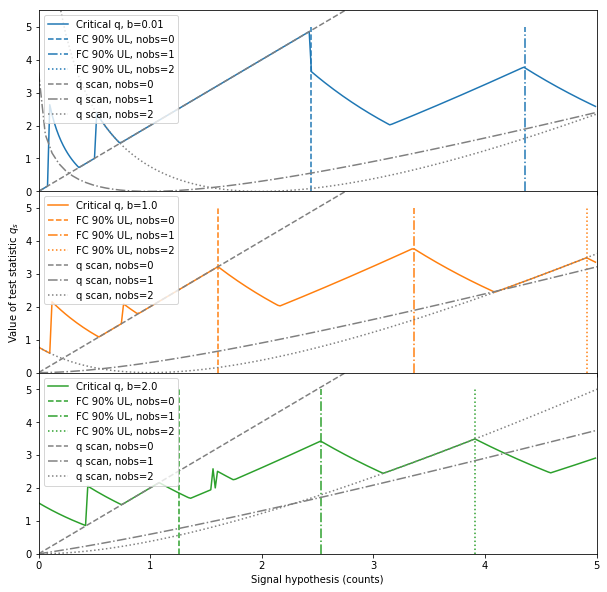

In [8]:
plt.rcParams['figure.figsize'] = (10,10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(ncols=1,nrows=3,sharex=True,gridspec_kw={'hspace':0.})

# Taken directly from the FC paper. 
# Note that for the b=0.01 case, I assume it's close enough to b=0

fc_lims_0 = {'0.01':2.44,'0.5':1.94,'1.0':1.61,\
             '1.5':1.33,'2.0':1.26,'2.5':1.18,\
             '3.0':1.08,'4.0':1.01}
fc_lims_1 = {'0.01':4.36,'0.5':3.86,'1.0':3.36,\
             '1.5':2.91,'2.0':2.53,'2.5':2.19,\
             '3.0':1.88,'4.0':1.39}
fc_lims_2 = {'0.01':5.91,'0.5':5.41,'1.0':4.91,\
             '1.5':4.41,'2.0':3.91,'2.5':3.45,\
             '3.0':3.04,'4.0':2.33}

counter =0
for bkg_str, array in bkg_limits_90.items():
#     if bkg_str == '0.1' or bkg_str == '0.3':
#         continue

    if bkg_str != '0.01' and \
        bkg_str != '1.0' and \
        bkg_str != '2.0':
        continue
    
    ax[counter].plot(hypotheses,array,label='Critical q, b={}'.format(bkg_str),\
                     color=colors[counter])
    print('Max for {}: {:4.4}'.format(bkg_str,hypotheses[np.argmax(array)]))
    
    ax[counter].plot(np.ones(5)*fc_lims_0[bkg_str],np.linspace(0.,5.,5),\
                     '--',color=colors[counter],linewidth=1.5,label='FC 90% UL, nobs=0')
    ax[counter].plot(np.ones(5)*fc_lims_1[bkg_str],np.linspace(0.,5.,5),\
                     '-.',color=colors[counter],linewidth=1.5,label='FC 90% UL, nobs=1')
    ax[counter].plot(np.ones(5)*fc_lims_2[bkg_str],np.linspace(0.,5.,5),\
                     ':',color=colors[counter],linewidth=1.5,label='FC 90% UL, nobs=2')
    xvals = np.linspace(0.,6.,100)
    ax[counter].plot(xvals,qscan(xvals,float(bkg_str),0),'--',\
                     color=(0.5,0.5,0.5),label='q scan, nobs=0')
    ax[counter].plot(xvals,qscan(xvals,float(bkg_str),1),'-.',\
                     color=(0.5,0.5,0.5),label='q scan, nobs=1')
    ax[counter].plot(xvals,qscan(xvals,float(bkg_str),2),':',\
                     color=(0.5,0.5,0.5),label='q scan, nobs=2')
    ax[counter].legend(loc='upper left',fontsize=10)
    ax[counter].set_xlim(0.,5.)
    ax[counter].set_ylim(0.,5.5)
    #ax[counter].grid()
        
    counter += 1
    
ax[counter-1].set_xlabel('Signal hypothesis (counts)')
ax[1].set_ylabel(r'Value of test statistic $q_s$')


Max for 0.01: 2.425
Max for 1.0: 3.347
Max for 2.0: 3.908
Max for 2.5: 3.447


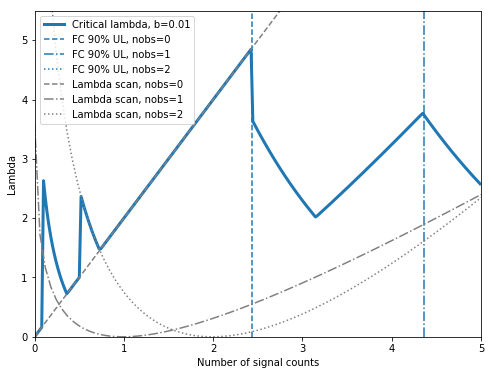

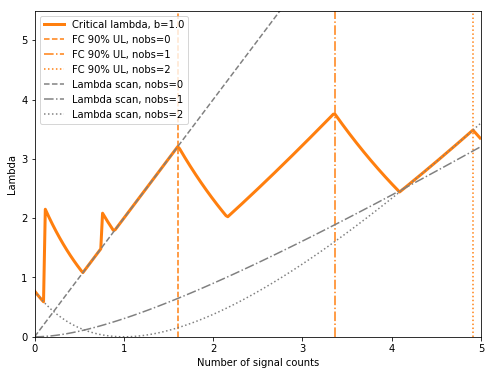

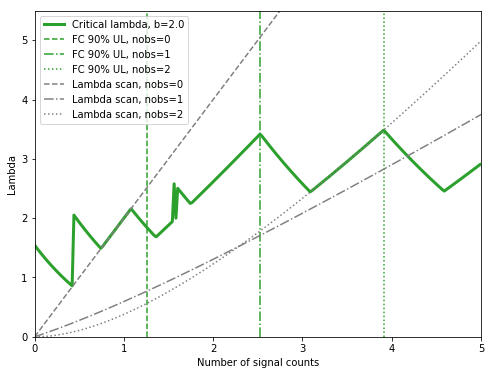

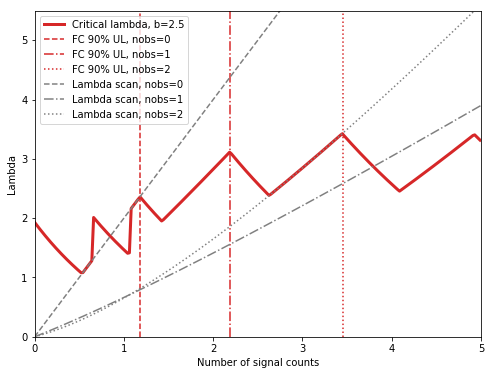

<Figure size 576x432 with 0 Axes>

In [9]:
plt.rcParams['figure.figsize'] = (8,6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fc_lims_0 = {'0.01':2.44,'0.5':1.94,'1.0':1.61,\
             '1.5':1.33,'2.0':1.26,'2.5':1.18,\
             '3.0':1.08,'4.0':1.01}
fc_lims_1 = {'0.01':4.36,'0.5':3.86,'1.0':3.36,\
             '1.5':2.91,'2.0':2.53,'2.5':2.19,\
             '3.0':1.88,'4.0':1.39}
fc_lims_2 = {'0.01':5.91,'0.5':5.41,'1.0':4.91,\
             '1.5':4.41,'2.0':3.91,'2.5':3.45,\
             '3.0':3.04,'4.0':2.33}

counter =0
for bkg_str, array in bkg_limits_90.items():
#     if bkg_str == '0.1' or bkg_str == '0.3':
#         continue

    plt.figure(counter)
    if bkg_str != '0.01' and \
        bkg_str != '1.0' and \
        bkg_str != '2.0' and \
        bkg_str != '2.5':
        continue
    
    plt.plot(hypotheses,array,label='Critical lambda, b={}'.format(bkg_str),\
                     color=colors[counter],linewidth=3)
    print('Max for {}: {:4.4}'.format(bkg_str,hypotheses[np.argmax(array)]))
    
    plt.plot(np.ones(5)*fc_lims_0[bkg_str],np.linspace(0.,6.,5),\
                     '--',color=colors[counter],linewidth=1.5,label='FC 90% UL, nobs=0')
    plt.plot(np.ones(5)*fc_lims_1[bkg_str],np.linspace(0.,6.,5),\
                     '-.',color=colors[counter],linewidth=1.5,label='FC 90% UL, nobs=1')
    plt.plot(np.ones(5)*fc_lims_2[bkg_str],np.linspace(0.,6.,5),\
                     ':',color=colors[counter],linewidth=1.5,label='FC 90% UL, nobs=2')
    xvals = np.linspace(0.,6.,100)
    plt.plot(xvals,qscan(xvals,float(bkg_str),0),'--',\
                     color=(0.5,0.5,0.5),label='Lambda scan, nobs=0')
    plt.plot(xvals,qscan(xvals,float(bkg_str),1),'-.',\
                     color=(0.5,0.5,0.5),label='Lambda scan, nobs=1')
    plt.plot(xvals,qscan(xvals,float(bkg_str),2),':',\
                     color=(0.5,0.5,0.5),label='Lambda scan, nobs=2')
    plt.legend(loc='upper left',fontsize=10)
    plt.xlim(0.,5.)
    plt.ylim(0.,5.5)
    #ax[counter].grid()
    
    plt.xlabel('Number of signal counts')
    plt.ylabel('Lambda')
    
#     plt.savefig('feldman_cousins_counting_exp_critical_lambda_{}bkg.png'.format(bkg_str),\
#                dpi=200,bbox_inches='tight')
        
    counter += 1

In [10]:
bkg_steps = np.linspace(0.,8.0,81)
upper_limits = []
fc_hypotheses = np.linspace(0.,4.99,125)
fc_bkg_limits_90 = []

for j in range(81):
    if j%10 == 0:
        print('Running {:3.3} bkg counts'.format(bkg_steps[j]))
    
    this_bkg_limits_90 = []
    
    for i in range(125):
        hyp = fc_hypotheses[i]

        test = np.random.poisson(lam=(hyp+bkg_steps[j]),size=10000)
        qtest = q_s(hyp,bkg_steps[j],test)

        this_bkg_limits_90.append(np.quantile(qtest,0.9))
        
    fc_bkg_limits_90.append(this_bkg_limits_90)
    
    
    
    




Running 0.0 bkg counts


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Running 1.0 bkg counts
Running 2.0 bkg counts
Running 3.0 bkg counts
Running 4.0 bkg counts
Running 5.0 bkg counts
Running 6.0 bkg counts
Running 7.0 bkg counts
Running 8.0 bkg counts


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


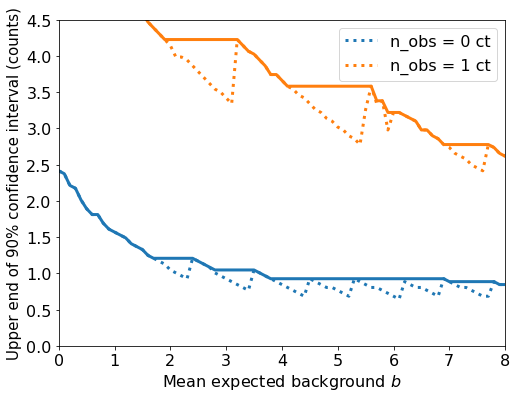

In [12]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16

upper_limits_0 = []
upper_limits_1 = []

svals = np.linspace(0.0,4.99,125)


for i in range(81):
    
    q0 = qscan(svals,0,0)
    q1 = qscan(svals,bkg_steps[i],1)
    
    upper_limit_0_idx = np.where(q0<=fc_bkg_limits_90[i])[0][-1]
    upper_limit_1_idx = np.where(q1<=fc_bkg_limits_90[i])[0][-1]
    
    upper_limits_0.append(fc_hypotheses[upper_limit_0_idx])
    upper_limits_1.append(fc_hypotheses[upper_limit_1_idx])

    
ul_0_np = np.array(upper_limits_0)
ul_1_np = np.array(upper_limits_1)

upper_limits_0_non_inc = []
upper_limits_1_non_inc = []
    
for i in range(len(upper_limits_0)-1):
    
    if np.max(ul_0_np[i+1:]) < ul_0_np[i]:
        upper_limits_0_non_inc.append(ul_0_np[i])
    else:
        upper_limits_0_non_inc.append(np.max(ul_0_np[i+1:]))
    if np.max(ul_1_np[i+1:]) < ul_1_np[i]:
        upper_limits_1_non_inc.append(ul_1_np[i])
    else:
        upper_limits_1_non_inc.append(np.max(ul_1_np[i+1:]))
    
upper_limits_0_non_inc.append(ul_0_np[-1])
upper_limits_1_non_inc.append(ul_1_np[-1])
    

plt.plot(bkg_steps,upper_limits_0,':',color=colors[0],label='n_obs = 0 ct',linewidth=3)
plt.plot(bkg_steps,upper_limits_0_non_inc,color=colors[0],linewidth=3)
plt.plot(bkg_steps,upper_limits_1,':',color=colors[1],label='n_obs = 1 ct',linewidth=3)
plt.plot(bkg_steps,upper_limits_1_non_inc,color=colors[1],linewidth=3)
plt.legend(fontsize=16)
plt.ylim(0.,4.5)
plt.xlim(0.,8.)

plt.xlabel(r'Mean expected background $b$')
plt.ylabel('Upper end of 90% confidence interval (counts)',fontsize=15)
plt.savefig('Plots/upper_limits_of_FC_intervals.png',dpi=200,bbox_inches='tight')



# Compare to the code output in the Ba-tagging case

/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


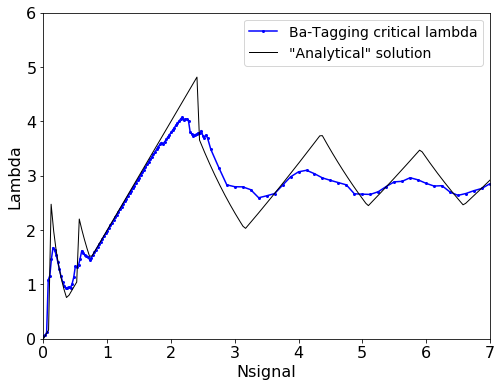

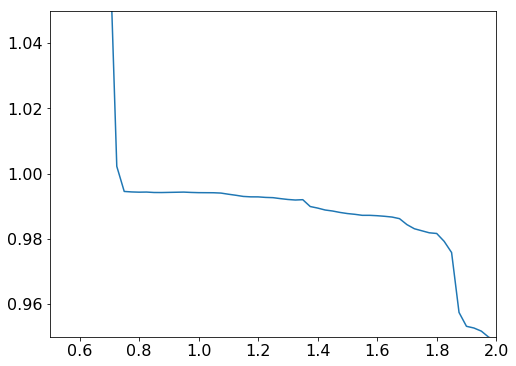

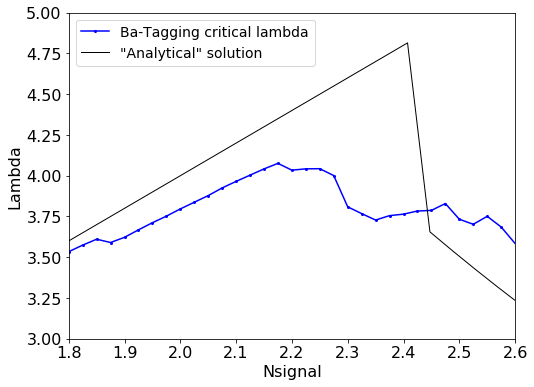

In [18]:
hypotheses = np.linspace(0.,9.99,num_hypotheses)

ba_tagging_critical_lambda = np.genfromtxt('CriticalLambdaCurves/critical_lambda_ba_tagging_fine.txt')
plt.plot(ba_tagging_critical_lambda[:,0],ba_tagging_critical_lambda[:,1],'-ob',\
         markersize=2,label='Ba-Tagging critical lambda')
plt.plot(hypotheses,limits_90,'-k',linewidth=1,label='\"Analytical\" solution')

plt.xlim(0.,7.)
plt.ylim(0.,6.)
plt.xlabel('Nsignal')
plt.ylabel('Lambda')
plt.legend(fontsize=14)
plt.savefig('Plots/critical_lambda_analytical0bkg_vs_calculated.png',dpi=200,bbox_inches='tight')

plt.figure(2)
plt.plot(ba_tagging_critical_lambda[:,0],ba_tagging_critical_lambda[:,1]/qscan(ba_tagging_critical_lambda[:,0],0,0))
plt.xlim(0.5,2.)
plt.ylim(0.95,1.05)

plt.figure(3)
plt.plot(ba_tagging_critical_lambda[:,0],ba_tagging_critical_lambda[:,1],'-ob',\
         markersize=2,label='Ba-Tagging critical lambda')
plt.plot(hypotheses,limits_90,'-k',linewidth=1,label='\"Analytical\" solution')

plt.xlim(1.8,2.6)
plt.ylim(3.,5.)
plt.xlabel('Nsignal')
plt.ylabel('Lambda')
plt.legend(fontsize=14)


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


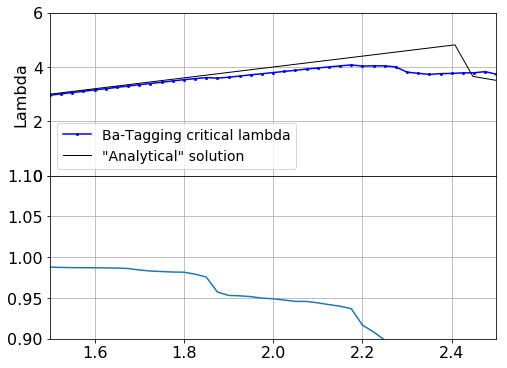

In [21]:
fig, ax = plt.subplots(ncols=1,nrows=2,sharex=True,gridspec_kw={'hspace':0.})

ba_tagging_critical_lambda = np.genfromtxt('CriticalLambdaCurves/critical_lambda_ba_tagging_fine.txt')
ax[0].plot(ba_tagging_critical_lambda[:,0],ba_tagging_critical_lambda[:,1],'-ob',\
         markersize=2,label='Ba-Tagging critical lambda')
ax[0].plot(hypotheses,limits_90,'-k',linewidth=1,label='\"Analytical\" solution')

ax[0].set_xlim(1.5,2.5)
ax[0].set_ylim(0.,6.)
ax[0].set_xlabel('Nsignal')
ax[0].set_ylabel('Lambda')
ax[0].legend(fontsize=14)
ax[0].grid()

ax[1].plot(ba_tagging_critical_lambda[:,0],ba_tagging_critical_lambda[:,1]/qscan(ba_tagging_critical_lambda[:,0],0,0))
ax[1].set_xlim(1.5,2.5)
ax[1].set_ylim(0.9,1.1)
ax[1].grid()




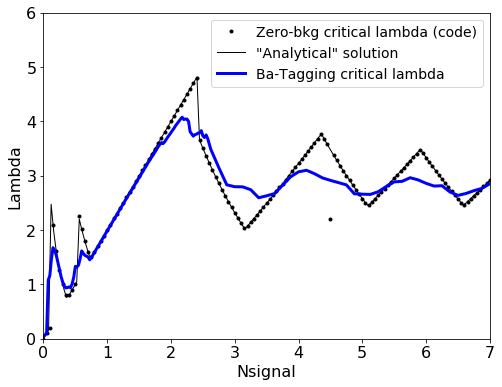

In [23]:
ba_tagging_critical_lambda = np.genfromtxt('CriticalLambdaCurves/critical_lambda_ba_tagging_fine.txt')
zero_bkg_fit_critical_lambda = np.genfromtxt('../ZeroBackgroundCountingExp/critical_lambda_0bkg_sensitivity_code.txt')


plt.plot(zero_bkg_fit_critical_lambda[:,0],zero_bkg_fit_critical_lambda[:,1],'ok',\
         markersize=3,label='Zero-bkg critical lambda (code)')
plt.plot(hypotheses,limits_90,'-k',linewidth=1,label='\"Analytical\" solution')
plt.plot(ba_tagging_critical_lambda[:,0],ba_tagging_critical_lambda[:,1],'-b',\
         linewidth=3,label='Ba-Tagging critical lambda')

plt.xlim(0.,7.)
plt.ylim(0.,6.)
plt.xlabel('Nsignal')
plt.ylabel('Lambda')
plt.legend(fontsize=14)
plt.savefig('Plots/critical_lambda_0bkg_vs_analytical_vs_ba_tagging.png',dpi=200,bbox_inches='tight')



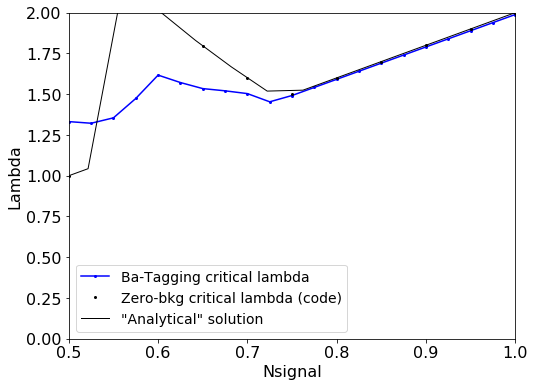

In [24]:
ba_tagging_critical_lambda = np.genfromtxt('CriticalLambdaCurves/critical_lambda_ba_tagging_fine.txt')
zero_bkg_fit_critical_lambda = np.genfromtxt('../ZeroBackgroundCountingExp/critical_lambda_0bkg_sensitivity_code.txt')

plt.plot(ba_tagging_critical_lambda[:,0],ba_tagging_critical_lambda[:,1],'-ob',\
         markersize=2,label='Ba-Tagging critical lambda')
plt.plot(zero_bkg_fit_critical_lambda[:,0],zero_bkg_fit_critical_lambda[:,1],'ok',\
         markersize=2,label='Zero-bkg critical lambda (code)')
plt.plot(hypotheses,limits_90,'-k',linewidth=1,label='\"Analytical\" solution')

plt.xlim(0.5,1.)
plt.ylim(0.,2.)
plt.xlabel('Nsignal')
plt.ylabel('Lambda')
plt.legend(fontsize=14)

/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


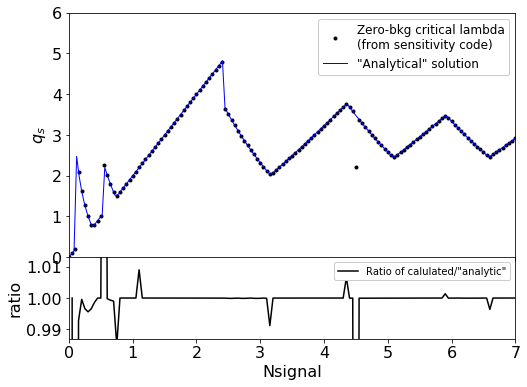

In [40]:
#ba_tagging_critical_lambda = np.genfromtxt('CriticalLambdaCurves/critical_lambda_ba_tagging_fine.txt')
fig, ax = plt.subplots(ncols=1,nrows=2,sharex=True,\
                       gridspec_kw={'hspace':0.,\
                                    'height_ratios':[3,1]})

zero_bkg_fit_critical_lambda = np.genfromtxt('../ZeroBackgroundCountingExp/critical_lambda_0bkg_sensitivity_code.txt')


ax[0].plot(zero_bkg_fit_critical_lambda[:,0],zero_bkg_fit_critical_lambda[:,1],'ok',\
         markersize=3,label='Zero-bkg critical lambda\n(from sensitivity code)')
ax[0].plot(hypotheses,limits_90,'-b',linewidth=1,label='\"Analytical\" solution')
#plt.plot(ba_tagging_critical_lambda[:,0],ba_tagging_critical_lambda[:,1],'-b',\
#         linewidth=3,label='Ba-Tagging critical lambda')

from scipy.interpolate import interp1d

analytic_model = interp1d(hypotheses,limits_90,kind='linear')
ax[1].plot(zero_bkg_fit_critical_lambda[:,0],\
           zero_bkg_fit_critical_lambda[:,1]/analytic_model(zero_bkg_fit_critical_lambda[:,0]),\
           '-k',markersize=3,label='Ratio of calulated/\"analytic\"')


ax[0].set_xlim(0.,7.)
ax[0].set_ylim(0.,6.)
ax[1].set_xlabel('Nsignal')
ax[0].set_ylabel(r'$q_s$')
ax[0].legend(fontsize=12,framealpha=1.)
ax[1].legend(fontsize=10,framealpha=1.,loc='upper right')

ax[1].set_ylim(0.987,1.013)
ax[1].set_ylabel('ratio')




plt.savefig('Plots/critical_lambda_0bkg_vs_analytical_vs_ba_tagging.png',dpi=200,bbox_inches='tight')

